In [42]:
# Cell 1 – Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import xgboost as xgb

print("Setup complete.")


Setup complete.


In [43]:
# Cell 2 – Load extracted features
print(os.listdir("/kaggle/input"))

FEATURES_PATH = "/kaggle/input/features-csv/features.csv.csv"  # adjust if needed
df = pd.read_csv(FEATURES_PATH)

print("Dataset shape:", df.shape)
display(df.head())


['features-csv']
Dataset shape: (34, 584)


,subject,file,segment,start_s,end_s,self_report,engagement_class,duration,mfcc_1_mean,mfcc_1_std,...,vfeat_508,vfeat_509,vfeat_510,vfeat_511,segment_high,segment_mid,segment_low,segment_read,segment_talk,segment_idle
0,sub01,sub01.mp4,high,3.0,31.0,5,high,28.0,-330.28217,38.383305,...,0.166632,0.802956,0.132247,0.196261,1.0,0.0,0.0,0.0,0.0,0.0
1,sub01,sub01.mp4,low,33.0,82.0,2,low,49.0,-377.83234,44.851612,...,0.210868,0.912421,0.103162,0.284469,0.0,0.0,1.0,0.0,0.0,0.0
2,sub01,sub01.mp4,talk,82.0,107.0,3,mid,25.0,-379.54200,44.595966,...,0.134236,0.938361,0.154042,0.236088,0.0,0.0,0.0,0.0,1.0,0.0
3,sub01,sub01.mp4,talk,107.0,146.0,4,high,39.0,-383.67667,37.099280,...,0.141579,1.036656,0.223603,0.341036,0.0,0.0,0.0,0.0,1.0,0.0
4,sub01,sub01.mp4,read,146.0,180.0,2,low,34.0,-378.46560,40.460320,...,0.127626,0.803469,0.112450,0.308088,0.0,0.0,0.0,1.0,0.0,0.0


In [44]:
meta_cols = ["subject", "file", "segment", "start_s", "end_s", "self_report", "engagement_class"]
feature_cols = [c for c in df.columns if c not in meta_cols]

X = df[feature_cols].values
y_text = df["engagement_class"].values  # "low", "mid", "high"

le = LabelEncoder()
y = le.fit_transform(y_text)

print("Classes:", le.classes_)
print("Feature dim:", X.shape[1])


Classes: ['high' 'low' 'mid']
Feature dim: 577


In [45]:
# Cell 3 – Engagement distribution
print("3-Class distribution:")
print(df["engagement_class"].value_counts())


3-Class distribution:
engagement_class
high    18
low      9
mid      7
Name: count, dtype: int64


In [53]:
# Audio features
audio_cols = [
    c for c in df.columns if c.startswith("mfcc_") or 
    c.startswith("spec_") or c.startswith("rolloff") or 
    c.startswith("zcr") or c.startswith("chroma_")
]

# Meta features
meta_cols_feat = ["duration"] + [c for c in df.columns if c.startswith("segment_")]

X_used = df[audio_cols + meta_cols_feat].values

# Binary labels
y_binary = np.where(df["engagement_class"] == "high", 1, 0)

print("✔️ Feature matrix:", X_used.shape)
print("Binary class distribution:", dict(zip(*np.unique(y_binary, return_counts=True))))


✔️ Feature matrix: (34, 65)
Binary class distribution: {0: 16, 1: 18}


In [54]:
def evaluate_model(pipeline, X, y, verbose=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs, f1s = [], []

    all_true, all_pred = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        accs.append(acc)
        f1s.append(f1)
        all_true.extend(y_test)
        all_pred.extend(preds)

    print("\n📊 FINAL Stratified 5-Fold CV")
    print(f"Accuracy: {np.mean(accs):.3f}")
    print(f"F1 Score: {np.mean(f1s):.3f}")

    print("\nClassification Report:")
    print(classification_report(all_true, all_pred, target_names=["non-high", "high"]))

    cm = confusion_matrix(all_true, all_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["non-high", "high"], yticklabels=["non-high", "high"])
    plt.show()

    return np.mean(accs), np.mean(f1s)


🚀 Running final XGBoost model (binary, audio+meta)...

📊 FINAL Stratified 5-Fold CV
Accuracy: 0.657
F1 Score: 0.623

Classification Report:
              precision    recall  f1-score   support

    non-high       0.67      0.50      0.57        16
        high       0.64      0.78      0.70        18

    accuracy                           0.65        34
   macro avg       0.65      0.64      0.64        34
weighted avg       0.65      0.65      0.64        34



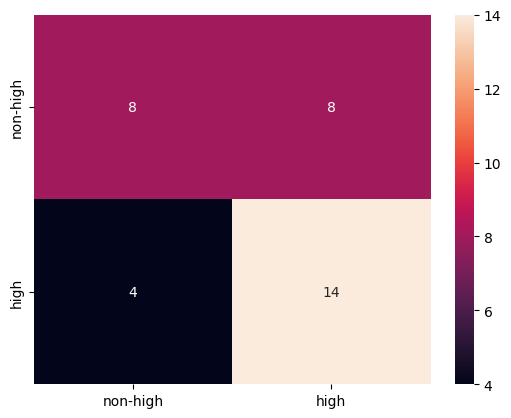

In [55]:
xgb_final = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3)),  # ← optimal
    ("clf", xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])

print(" Running final XGBoost model (binary, audio+meta)...")
acc_final, f1_final = evaluate_model(xgb_final, X_used, y_binary)
